<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/yolov2_pre_trained_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import argparse
import time
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image=cv2.imread('/content/download4.jpg')
(H, W) = image.shape[:2]
yolo='/content/drive/My Drive/yoloy_opencv/yolo-coco2'
conf=0.5
threshold=0.3

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
lab=os.path.join('/content/drive/My Drive/yoloy_opencv/yolo-coco2','coco.names')
print(lab)
LABELS = open(lab).read().strip().split("\n")

print(LABELS)

/content/drive/My Drive/yoloy_opencv/yolo-coco2/coco.names
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [0]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")
# print(COLORS)

In [118]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join('/content/drive/My Drive/yoloy_opencv/yolo-coco2', "yolov2.weights")
configPath = os.path.join('/content/drive/My Drive/yoloy_opencv/yolo-coco2', "yolov2.cfg")
 
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [119]:
ln = net.getLayerNames()
print(ln)
print(len(ln))
print(net.getUnconnectedOutLayers())
print(net.getUnconnectedOutLayers().shape)
for i in net.getUnconnectedOutLayers():
  print(i,end="  ")
print()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(ln)
print(len(ln))

['conv_0', 'bn_0', 'relu_0', 'pool_1', 'conv_2', 'bn_2', 'relu_2', 'pool_3', 'conv_4', 'bn_4', 'relu_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'pool_7', 'conv_8', 'bn_8', 'relu_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'pool_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'conv_15', 'bn_15', 'relu_15', 'conv_16', 'bn_16', 'relu_16', 'pool_17', 'conv_18', 'bn_18', 'relu_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'conv_21', 'bn_21', 'relu_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'conv_24', 'bn_24', 'relu_24', 'identity_25', 'conv_26', 'bn_26', 'relu_26', 'reorg_27', 'concat_28', 'conv_29', 'bn_29', 'relu_29', 'conv_30', 'permute_31', 'detection_out']
77
[[77]]
(1, 1)
[77]  
['detection_out']
1


In [120]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
print("[INFO] YOLO took {:.6f} seconds".format(end - start))
print(len(layerOutputs))
print(len(layerOutputs[0][0]))

[INFO] YOLO took 1.109656 seconds
1
85


In [0]:
boxes = []
confidences = []
classIDs = []

In [0]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]

		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > conf:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")

			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))

			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [123]:
print(len(boxes))

5


In [124]:
# apply non-maxima suppression to suppress weak, overlapping bounding
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf,threshold)
print(len(idxs))
print(idxs.flatten())

5
[2 3 1 0 4]


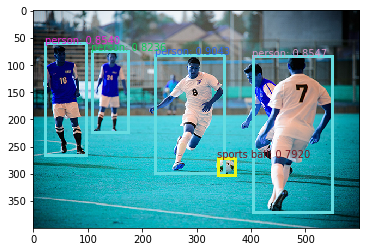

In [126]:
# ensure at least one detection exists
if len(idxs) > 0:
  fig,ax = plt.subplots(1)
  ax.imshow(image )

	# loop over the indexes we are keeping
  for i in idxs.flatten():
    # extract the bounding box coordinates
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    length,height=w,h
    # draw a bounding box rectangle and label on the image
    color = [int(c)/255 for c in COLORS[classIDs[i]]]
    # print(classIDs[i])
    flag=(i+np.random.randint(0,25))%20
    textcolor=[int(c)/255 for c in COLORS[flag]]
    # cv2_rectangle(image, (x, y), (x + w, y + h), color, 2)
    # text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
    # cv2_putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
    # 	0.5, color, 2)
    rect = patches.Rectangle((x,y),length,height,linewidth=3,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
    ax.text(x/W,1-y/H, "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i]),transform=ax.transAxes,color=textcolor)
  plt.show()


In [71]:
for j in layerOutputs:
  print(j.shape)
  print(j[0])
  break

(85,)
0.0071457657
